In [2]:
!pip install pyspark
!pip install nltk
!pip install pandas
!pip install matplotlib
!pip install gensim
!pip install pyldavis
!pip install spacy
!pip install validators

In [3]:

import re
import numpy as np
import pandas as pd
from pprint import pprint
import multiprocessing as mp
import validators
import string

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)



# Paso 1: Clasificación de texto/ Preparación de datos 


In [4]:
df = pd.read_csv('sources/metadata.csv')
print("Cols names: {}".format(df.columns))
df.head()

Cols names: Index(['cord_uid', 'sha', 'source_x', 'title', 'doi', 'pmcid', 'pubmed_id',
       'license', 'abstract', 'publish_time', 'authors', 'journal', 'mag_id',
       'who_covidence_id', 'arxiv_id', 'pdf_json_files', 'pmc_json_files',
       'url'],
      dtype='object')


/Users/jzapatam/.conda/envs/TallerPython/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


cord_uid                                       sha source_x  \
0  zjufx4fo  b2897e1277f56641193a6db73825f707eed3e4c9      PMC   
1  ymceytj3  e3d0d482ebd9a8ba81c254cc433f314142e72174      PMC   
2  wzj2glte  00b1d99e70f779eb4ede50059db469c65e8c1469      PMC   
3  2sfqsfm1  cf584e00f637cbd8f1bb35f3f09f5ed07b71aeb0      PMC   
4  i0zym7iq  dde02f11923815e6a16a31dd6298c46b109c5dfa      PMC   

                                               title  \
0  Sequence requirements for RNA strand transfer ...   
1  Crystal structure of murine sCEACAM1a[1,4]: a ...   
2  Synthesis of a novel hepatitis C virus protein...   
3  Structure of coronavirus main proteinase revea...   
4  Discontinuous and non-discontinuous subgenomic...   

                        doi      pmcid   pubmed_id   license  \
0  10.1093/emboj/20.24.7220  PMC125340  11742998.0  green-oa   
1   10.1093/emboj/21.9.2076  PMC125375  11980704.0  green-oa   
2  10.1093/emboj/20.14.3840  PMC125543  11447125.0     no-cc   
3      10.1093/emboj/cdf327  PMC126080  12093723.0  green-oa   
4      10.1093/emboj/cdf635  PMC136939  12456663.0  green-oa   

                                            abstract publish_time  \
0  Nidovirus subgenomic mRNAs contain a leader se...   2001-12-17   
1  CEACAM1 is a member of the carcinoembryonic an...   2002-05-01   
2  Hepatitis C virus (HCV) is an important human ...   2001-07-16   
3  The key enzyme in coronavirus polyprotein proc...   2002-07-01   
4  Arteri-, corona-, toro- and roniviruses are ev...   2002-12-01   

                                             authors           journal  \
0  Pasternak, Alexander O.; van den Born, Erwin; ...  The EMBO Journal   
1  Tan, Kemin; Zelus, Bruce D.; Meijers, Rob; Liu...  The EMBO Journal   
2  Xu, Zhenming; Choi, Jinah; Yen, T.S.Benedict; ...            EMBO J   
3  Anand, Kanchan; Palm, Gottfried J.; Mesters, J...  The EMBO Journal   
4  van Vliet, A.L.W.; Smits, S.L.; Rottier, P.J.M...  The EMBO Journal   

   mag_id who_covidence_id arxiv_id  \
0     NaN              NaN      NaN   
1     NaN              NaN      NaN   
2     NaN              NaN      NaN   
3     NaN              NaN      NaN   
4     NaN              NaN      NaN   

                                      pdf_json_files  \
0  document_parses/pdf_json/b2897e1277f56641193a6...   
1  document_parses/pdf_json/e3d0d482ebd9a8ba81c25...   
2  document_parses/pdf_json/00b1d99e70f779eb4ede5...   
3  document_parses/pdf_json/cf584e00f637cbd8f1bb3...   
4  document_parses/pdf_json/dde02f11923815e6a16a3...   

                                pmc_json_files  \
0  document_parses/pmc_json/PMC125340.xml.json   
1  document_parses/pmc_json/PMC125375.xml.json   
2  document_parses/pmc_json/PMC125543.xml.json   
3  document_parses/pmc_json/PMC126080.xml.json   
4  document_parses/pmc_json/PMC136939.xml.json   

                                                 url  
0  http://europepmc.org/articles/pmc125340?pdf=re...  
1  http://europepmc.org/articles/pmc125375?pdf=re...  
2  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...  
3  http://europepmc.org/articles/pmc126080?pdf=re...  
4  http://europepmc.org/articles/pmc136939?pdf=re...

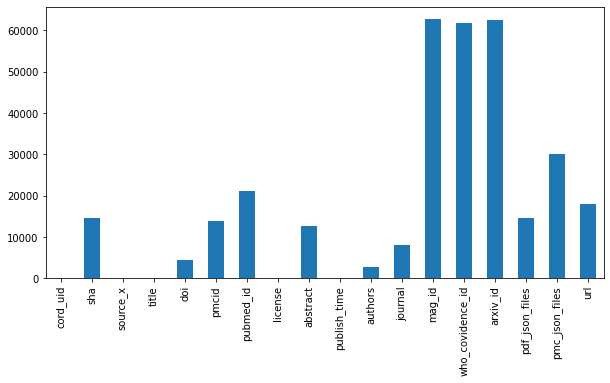

In [5]:
plt.figure(figsize=(10,5))
df.isna().sum().plot(kind='bar', stacked=True)

Se identifican las caracteristicas que tienen valores faltantes de acuerdo con el histograma, a continuación evaluaremos los faltantes y eliminaremos algunos para regular la escala de las frecuencias 

In [6]:
df.columns

Index(['cord_uid', 'sha', 'source_x', 'title', 'doi', 'pmcid', 'pubmed_id',
       'license', 'abstract', 'publish_time', 'authors', 'journal', 'mag_id',
       'who_covidence_id', 'arxiv_id', 'pdf_json_files', 'pmc_json_files',
       'url'],
      dtype='object')

In [7]:
miss = df['abstract'].isna().sum()
print("El número de papers sin abstracts es {:0.0f} que representa {:.2f}% del numero total de papers".format(miss, 100* (miss/df.shape[0])))

El número de papers sin abstracts es 12559 que representa 19.76% del numero total de papers


In [8]:
abstracts_papers = df[df['abstract'].notna()]
print("El número total de papers {:0.0f}".format(abstracts_papers.shape[0]))
missing_doi = abstracts_papers['doi'].isna().sum()
print("El número de papers sin doi es {:0.0f}".format(missing_doi))
missing_url = abstracts_papers['url'].isna().sum()
print("El número de papers sin url es {:0.0f}".format(missing_url))

El número total de papers 51012
El número de papers sin doi es 3645
El número de papers sin url es 14214


In [9]:
abstracts_papers = abstracts_papers[abstracts_papers['publish_time'].notna()]
abstracts_papers['year'] = pd.DatetimeIndex(abstracts_papers['publish_time']).year

In [10]:
def remove_invalid_ur(url):
    '''Remove invalid url'''
    valid = validators.url(url)
    if valid:
       return url 
    else:
       return None 

In [11]:
abstracts_papers['url'] = abstracts_papers.apply(lambda row: remove_invalid_ur(str(row['url'])), axis=1)
missing_url_data = abstracts_papers[abstracts_papers["url"].notna()]
print("El número total de papers con abstracts, urls, pero que les falta doi = {:.0f}".format( missing_url_data.doi.isna().sum()))


El número total de papers con abstracts, urls, pero que les falta doi = 2321


In [12]:
abstracts_papers = abstracts_papers[abstracts_papers["url"].notna()]

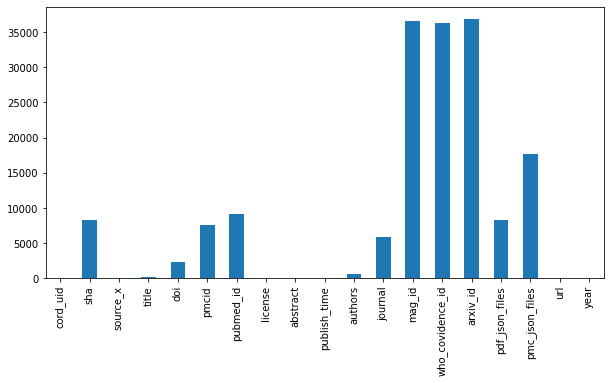

In [13]:
#esquema de los datos 
plt.figure(figsize=(10,5))
abstracts_papers.isna().sum().plot(kind='bar', stacked=True)

In [14]:
abstracts_papers.head()

cord_uid                                       sha source_x  \
0  zjufx4fo  b2897e1277f56641193a6db73825f707eed3e4c9      PMC   
1  ymceytj3  e3d0d482ebd9a8ba81c254cc433f314142e72174      PMC   
2  wzj2glte  00b1d99e70f779eb4ede50059db469c65e8c1469      PMC   
3  2sfqsfm1  cf584e00f637cbd8f1bb35f3f09f5ed07b71aeb0      PMC   
4  i0zym7iq  dde02f11923815e6a16a31dd6298c46b109c5dfa      PMC   

                                               title  \
0  Sequence requirements for RNA strand transfer ...   
1  Crystal structure of murine sCEACAM1a[1,4]: a ...   
2  Synthesis of a novel hepatitis C virus protein...   
3  Structure of coronavirus main proteinase revea...   
4  Discontinuous and non-discontinuous subgenomic...   

                        doi      pmcid   pubmed_id   license  \
0  10.1093/emboj/20.24.7220  PMC125340  11742998.0  green-oa   
1   10.1093/emboj/21.9.2076  PMC125375  11980704.0  green-oa   
2  10.1093/emboj/20.14.3840  PMC125543  11447125.0     no-cc   
3      10.1093/emboj/cdf327  PMC126080  12093723.0  green-oa   
4      10.1093/emboj/cdf635  PMC136939  12456663.0  green-oa   

                                            abstract publish_time  \
0  Nidovirus subgenomic mRNAs contain a leader se...   2001-12-17   
1  CEACAM1 is a member of the carcinoembryonic an...   2002-05-01   
2  Hepatitis C virus (HCV) is an important human ...   2001-07-16   
3  The key enzyme in coronavirus polyprotein proc...   2002-07-01   
4  Arteri-, corona-, toro- and roniviruses are ev...   2002-12-01   

                                             authors           journal  \
0  Pasternak, Alexander O.; van den Born, Erwin; ...  The EMBO Journal   
1  Tan, Kemin; Zelus, Bruce D.; Meijers, Rob; Liu...  The EMBO Journal   
2  Xu, Zhenming; Choi, Jinah; Yen, T.S.Benedict; ...            EMBO J   
3  Anand, Kanchan; Palm, Gottfried J.; Mesters, J...  The EMBO Journal   
4  van Vliet, A.L.W.; Smits, S.L.; Rottier, P.J.M...  The EMBO Journal   

   mag_id who_covidence_id arxiv_id  \
0     NaN              NaN      NaN   
1     NaN              NaN      NaN   
2     NaN              NaN      NaN   
3     NaN              NaN      NaN   
4     NaN              NaN      NaN   

                                      pdf_json_files  \
0  document_parses/pdf_json/b2897e1277f56641193a6...   
1  document_parses/pdf_json/e3d0d482ebd9a8ba81c25...   
2  document_parses/pdf_json/00b1d99e70f779eb4ede5...   
3  document_parses/pdf_json/cf584e00f637cbd8f1bb3...   
4  document_parses/pdf_json/dde02f11923815e6a16a3...   

                                pmc_json_files  \
0  document_parses/pmc_json/PMC125340.xml.json   
1  document_parses/pmc_json/PMC125375.xml.json   
2  document_parses/pmc_json/PMC125543.xml.json   
3  document_parses/pmc_json/PMC126080.xml.json   
4  document_parses/pmc_json/PMC136939.xml.json   

                                                 url  year  
0  http://europepmc.org/articles/pmc125340?pdf=re...  2001  
1  http://europepmc.org/articles/pmc125375?pdf=re...  2002  
2  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...  2001  
3  http://europepmc.org/articles/pmc126080?pdf=re...  2002  
4  http://europepmc.org/articles/pmc136939?pdf=re...  2002

In [15]:
#Extraer las columnas de interes
col = ['title','abstract','year','authors','journal']
df = abstracts_papers[col]
df

title  \
0      Sequence requirements for RNA strand transfer ...   
1      Crystal structure of murine sCEACAM1a[1,4]: a ...   
2      Synthesis of a novel hepatitis C virus protein...   
3      Structure of coronavirus main proteinase revea...   
4      Discontinuous and non-discontinuous subgenomic...   
...                                                  ...   
63394  C-E1 Fusion Protein Synthesized by Rubella Vir...   
63395  Genetic Susceptibility to Feline Infectious Pe...   
63426  Delivery to the lower respiratory tract is req...   
63427  Global Transport Networks and Infectious Disea...   
63430  A research agenda for aging in China in the 21...   

                                                abstract  year  \
0      Nidovirus subgenomic mRNAs contain a leader se...  2001   
1      CEACAM1 is a member of the carcinoembryonic an...  2002   
2      Hepatitis C virus (HCV) is an important human ...  2001   
3      The key enzyme in coronavirus polyprotein proc...  2002   
4      Arteri-, corona-, toro- and roniviruses are ev...  2002   
...                                                  ...   ...   
63394  Rubella virus (RUB) replicons are derivatives ...  2006   
63395  Genetic factors are presumed to influence the ...  2013   
63426  Newcastle disease virus (NDV), an avian virus,...  2009   
63427  Air, sea and land transport networks continue ...  2006   
63430  China is encountering formidable healthcare ch...  2015   

                                                 authors  \
0      Pasternak, Alexander O.; van den Born, Erwin; ...   
1      Tan, Kemin; Zelus, Bruce D.; Meijers, Rob; Liu...   
2      Xu, Zhenming; Choi, Jinah; Yen, T.S.Benedict; ...   
3      Anand, Kanchan; Palm, Gottfried J.; Mesters, J...   
4      van Vliet, A.L.W.; Smits, S.L.; Rottier, P.J.M...   
...                                                  ...   
63394                     Tzeng, Wen-Pin; Frey, Teryl K.   
63395  Golovko, Lyudmila; Lyons, Leslie A.; Liu, Hong...   
63426  DiNapoli, Joshua M.; Ward, Jerrold M.; Cheng, ...   
63427               Tatem, A.J.; Rogers, D.J.; Hay, S.I.   
63430  Fang, Evandro Fei; Scheibye-Knudsen, Morten; J...   

                                                 journal  
0                                       The EMBO Journal  
1                                       The EMBO Journal  
2                                                 EMBO J  
3                                       The EMBO Journal  
4                                       The EMBO Journal  
...                                                  ...  
63394                                           Virology  
63395                                     Virus Research  
63426                                            Vaccine  
63427  Global Mapping of Infectious Diseases: Methods...  
63430                            Ageing Research Reviews  

[36798 rows x 5 columns]

## Preparación de los datos (se remueven signos se puntuación, se convierte todo a minuscula y se hace stemmig y lemma)

In [16]:
def clean_text_round1(text):
    '''make text lowercase, remove punctuation.'''
    text = text.lower()
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    return text

round1 = lambda x: clean_text_round1(str(x))

In [17]:
df.title = df.title.apply(round1)
df.abstract = df.abstract.apply(round1)
df.authors = df.authors.apply(round1)
df.journal = df.journal.apply(round1)
df

/Users/jzapatam/.conda/envs/TallerPython/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


title  \
0      sequence requirements for rna strand transfer ...   
1      crystal structure of murine sceacam1a14 a coro...   
2      synthesis of a novel hepatitis c virus protein...   
3      structure of coronavirus main proteinase revea...   
4      discontinuous and nondiscontinuous subgenomic ...   
...                                                  ...   
63394  ce1 fusion protein synthesized by rubella viru...   
63395  genetic susceptibility to feline infectious pe...   
63426  delivery to the lower respiratory tract is req...   
63427  global transport networks and infectious disea...   
63430  a research agenda for aging in china in the 21...   

                                                abstract  year  \
0      nidovirus subgenomic mrnas contain a leader se...  2001   
1      ceacam1 is a member of the carcinoembryonic an...  2002   
2      hepatitis c virus hcv is an important human pa...  2001   
3      the key enzyme in coronavirus polyprotein proc...  2002   
4      arteri corona toro and roniviruses are evoluti...  2002   
...                                                  ...   ...   
63394  rubella virus rub replicons are derivatives of...  2006   
63395  genetic factors are presumed to influence the ...  2013   
63426  newcastle disease virus ndv an avian virus is ...  2009   
63427  air sea and land transport networks continue t...  2006   
63430  china is encountering formidable healthcare ch...  2015   

                                                 authors  \
0      pasternak alexander o van den born erwin spaan...   
1      tan kemin zelus bruce d meijers rob liu jinhua...   
2      xu zhenming choi jinah yen tsbenedict lu wen s...   
3      anand kanchan palm gottfried j mesters jeroen ...   
4         van vliet alw smits sl rottier pjm de groot rj   
...                                                  ...   
63394                          tzeng wenpin frey teryl k   
63395  golovko lyudmila lyons leslie a liu hongwei so...   
63426  dinapoli joshua m ward jerrold m cheng lily ya...   
63427                          tatem aj rogers dj hay si   
63430  fang evandro fei scheibyeknudsen morten jahn h...   

                                                 journal  
0                                       the embo journal  
1                                       the embo journal  
2                                                 embo j  
3                                       the embo journal  
4                                       the embo journal  
...                                                  ...  
63394                                           virology  
63395                                     virus research  
63426                                            vaccine  
63427  global mapping of infectious diseases methods ...  
63430                            ageing research reviews  

[36798 rows x 5 columns]

In [18]:
df_abs = df[['abstract']]
df_abs

abstract
0      nidovirus subgenomic mrnas contain a leader se...
1      ceacam1 is a member of the carcinoembryonic an...
2      hepatitis c virus hcv is an important human pa...
3      the key enzyme in coronavirus polyprotein proc...
4      arteri corona toro and roniviruses are evoluti...
...                                                  ...
63394  rubella virus rub replicons are derivatives of...
63395  genetic factors are presumed to influence the ...
63426  newcastle disease virus ndv an avian virus is ...
63427  air sea and land transport networks continue t...
63430  china is encountering formidable healthcare ch...

[36798 rows x 1 columns]

In [19]:
## Tokenizacion y cleaning de palabras

In [20]:
def clean_text_round1(text):
    '''make text lowercase, remove punctuation.'''
    text = text.lower()
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    return text

clean_round1 = lambda x: clean_text_round1(str(x))

In [21]:
df_abs.abstract = df_abs.abstract.apply(clean_round1)

/Users/jzapatam/.conda/envs/TallerPython/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [22]:
# Convert to list
data = df_abs.abstract.values.tolist()
pprint(data[:1])



['nidovirus subgenomic mrnas contain a leader sequence derived from the 5′ end '
 'of the genome fused to different sequences ‘bodies’ derived from the 3′ end '
 'their generation involves a unique mechanism of discontinuous subgenomic rna '
 'synthesis that resembles copychoice rna recombination during this process '
 'the nascent rna strand is transferred from one site in the template to '
 'another during either plus or minus strand synthesis to yield subgenomic rna '
 'molecules central to this process are transcriptionregulating sequences trss '
 'which are present at both template sites and ensure the fidelity of strand '
 'transfer here we present results of a comprehensive covariation mutagenesis '
 'study of equine arteritis virus trss demonstrating that discontinuous rna '
 'synthesis depends not only on base pairing between sense leader trs and '
 'antisense body trs but also on the primary sequence of the body trs while '
 'the leader trs merely plays a targeting role for s

In [23]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations


In [24]:

data_words = list(sent_to_words(df_abs.abstract))
print(data_words[:1])
print(len(data_words))
 

[['nidovirus', 'subgenomic', 'mrnas', 'contain', 'leader', 'sequence', 'derived', 'from', 'the', 'end', 'of', 'the', 'genome', 'fused', 'to', 'different', 'sequences', 'bodies', 'derived', 'from', 'the', 'end', 'their', 'generation', 'involves', 'unique', 'mechanism', 'of', 'discontinuous', 'subgenomic', 'rna', 'synthesis', 'that', 'resembles', 'copychoice', 'rna', 'recombination', 'during', 'this', 'process', 'the', 'nascent', 'rna', 'strand', 'is', 'transferred', 'from', 'one', 'site', 'in', 'the', 'template', 'to', 'another', 'during', 'either', 'plus', 'or', 'minus', 'strand', 'synthesis', 'to', 'yield', 'subgenomic', 'rna', 'molecules', 'central', 'to', 'this', 'process', 'are', 'sequences', 'trss', 'which', 'are', 'present', 'at', 'both', 'template', 'sites', 'and', 'ensure', 'the', 'fidelity', 'of', 'strand', 'transfer', 'here', 'we', 'present', 'results', 'of', 'comprehensive', 'covariation', 'mutagenesis', 'study', 'of', 'equine', 'arteritis', 'virus', 'trss', 'demonstrating',

In [25]:
for i in range(len(data_words)): 
    # removing special characteres
    data_words[i] = [w for w in data_words[i] if w.isalpha()]  
    
    # deleting tokens that contains non-ascii characteres
    data_words[i] = [w.encode('ascii', 'ignore').decode('ascii') for w in data_words[i]]
    
    # removing tokens with len less or equal than 1
    data_words[i] = [w for w in data_words[i] if len(w)>1]
    
print(data_words[:1])
print(len(data_words))

[['nidovirus', 'subgenomic', 'mrnas', 'contain', 'leader', 'sequence', 'derived', 'from', 'the', 'end', 'of', 'the', 'genome', 'fused', 'to', 'different', 'sequences', 'bodies', 'derived', 'from', 'the', 'end', 'their', 'generation', 'involves', 'unique', 'mechanism', 'of', 'discontinuous', 'subgenomic', 'rna', 'synthesis', 'that', 'resembles', 'copychoice', 'rna', 'recombination', 'during', 'this', 'process', 'the', 'nascent', 'rna', 'strand', 'is', 'transferred', 'from', 'one', 'site', 'in', 'the', 'template', 'to', 'another', 'during', 'either', 'plus', 'or', 'minus', 'strand', 'synthesis', 'to', 'yield', 'subgenomic', 'rna', 'molecules', 'central', 'to', 'this', 'process', 'are', 'sequences', 'trss', 'which', 'are', 'present', 'at', 'both', 'template', 'sites', 'and', 'ensure', 'the', 'fidelity', 'of', 'strand', 'transfer', 'here', 'we', 'present', 'results', 'of', 'comprehensive', 'covariation', 'mutagenesis', 'study', 'of', 'equine', 'arteritis', 'virus', 'trss', 'demonstrating',

In [26]:
print(len(data_words))


36798


In [27]:
## Creacion de los modelos de Bigram y Trigram


In [28]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

In [29]:
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)


In [30]:
# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])



['nidovirus', 'subgenomic_mrnas', 'contain', 'leader', 'sequence', 'derived', 'from', 'the', 'end', 'of', 'the', 'genome', 'fused', 'to', 'different', 'sequences', 'bodies', 'derived', 'from', 'the', 'end', 'their', 'generation', 'involves', 'unique', 'mechanism', 'of', 'discontinuous', 'subgenomic', 'rna', 'synthesis', 'that', 'resembles', 'copychoice', 'rna', 'recombination', 'during', 'this', 'process', 'the', 'nascent', 'rna', 'strand', 'is', 'transferred', 'from', 'one', 'site', 'in', 'the', 'template', 'to', 'another', 'during', 'either', 'plus', 'or', 'minus_strand', 'synthesis', 'to', 'yield', 'subgenomic', 'rna', 'molecules', 'central', 'to', 'this', 'process', 'are', 'sequences_trss', 'which', 'are', 'present', 'at', 'both', 'template', 'sites', 'and', 'ensure', 'the', 'fidelity', 'of', 'strand', 'transfer', 'here', 'we', 'present', 'results', 'of', 'comprehensive', 'covariation', 'mutagenesis', 'study', 'of', 'equine_arteritis', 'virus', 'trss', 'demonstrating', 'that', 'dis

In [31]:

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [32]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [33]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

In [34]:
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

In [35]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

In [36]:
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])



In [37]:
print(data_lemmatized[:1])

[['leader', 'sequence', 'derive', 'end', 'genome', 'fuse', 'different', 'sequence', 'body', 'derive', 'end', 'generation', 'involve', 'unique', 'mechanism', 'discontinuous', 'synthesis', 'resemble', 'process', 'transfer', 'site', 'template', 'synthesis', 'yield', 'molecule', 'process', 'present', 'template', 'site', 'ensure', 'strand', 'transfer', 'present', 'result', 'comprehensive', 'covariation', 'mutagenesis', 'study', 'virus', 'trss', 'demonstrate', 'discontinuous', 'synthesis', 'depend', 'sense', 'also', 'primary', 'sequence', 'merely', 'play', 'target', 'role', 'strand', 'transfer', 'fulfil', 'multiple', 'leader', 'body', 'junction', 'mutant', 'strongly', 'suggest', 'discontinuous', 'step', 'occur', 'synthesis']]


## Creacion de dicionario y corpus

In [38]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
print(f'tamaño del diccionario: {len(id2word)}')

In [39]:
# Create Corpus
texts = data_lemmatized

In [40]:
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [41]:
print(corpus[:1])



[[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 2), (7, 1), (8, 3), (9, 2), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 2), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 2), (27, 1), (28, 2), (29, 1), (30, 1), (31, 1), (32, 1), (33, 3), (34, 2), (35, 1), (36, 2), (37, 1), (38, 1), (39, 1), (40, 4), (41, 1), (42, 2), (43, 3), (44, 1), (45, 1), (46, 1), (47, 1)]]


In [42]:
#ver el sorpus de forma lejible, es decir cada palabra con su frecuencia

[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]



[[('also', 1),
  ('body', 2),
  ('comprehensive', 1),
  ('covariation', 1),
  ('demonstrate', 1),
  ('depend', 1),
  ('derive', 2),
  ('different', 1),
  ('discontinuous', 3),
  ('end', 2),
  ('ensure', 1),
  ('fulfil', 1),
  ('fuse', 1),
  ('generation', 1),
  ('genome', 1),
  ('involve', 1),
  ('junction', 1),
  ('leader', 2),
  ('mechanism', 1),
  ('merely', 1),
  ('molecule', 1),
  ('multiple', 1),
  ('mutagenesis', 1),
  ('mutant', 1),
  ('occur', 1),
  ('play', 1),
  ('present', 2),
  ('primary', 1),
  ('process', 2),
  ('resemble', 1),
  ('result', 1),
  ('role', 1),
  ('sense', 1),
  ('sequence', 3),
  ('site', 2),
  ('step', 1),
  ('strand', 2),
  ('strongly', 1),
  ('study', 1),
  ('suggest', 1),
  ('synthesis', 4),
  ('target', 1),
  ('template', 2),
  ('transfer', 3),
  ('trss', 1),
  ('unique', 1),
  ('virus', 1),
  ('yield', 1)]]

## Craecion del Modelo LDA


In [43]:
lda_model = gensim.models.ldamulticore.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)



In [44]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(24,
  '0.163*"cancer" + 0.116*"young" + 0.076*"panel" + 0.064*"solution" + '
  '0.056*"density" + 0.040*"fluid" + 0.040*"fluorescent" + 0.036*"conjugate" + '
  '0.034*"polymorphism" + 0.025*"perceive"'),
 (28,
  '0.308*"specie" + 0.130*"identification" + 0.088*"organism" + '
  '0.064*"diversity" + 0.061*"separate" + 0.050*"minimal" + 0.025*"one" + '
  '0.020*"otherwise" + 0.016*"conservation" + 0.015*"reactive"'),
 (23,
  '0.166*"laboratory" + 0.103*"temperature" + 0.058*"preparation" + '
  '0.056*"terminal" + 0.053*"majority" + 0.047*"intermediate" + 0.042*"fall" + '
  '0.040*"frameshift" + 0.033*"translational" + 0.033*"adjacent"'),
 (0,
  '0.214*"peptide" + 0.172*"molecule" + 0.121*"correlate" + 0.072*"diverse" + '
  '0.044*"seek" + 0.035*"measurement" + 0.030*"augment" + 0.028*"hypothesize" '
  '+ 0.018*"extreme" + 0.017*"migration"'),
 (22,
  '0.174*"testing" + 0.132*"technology" + 0.096*"line" + 0.080*"advance" + '
  '0.068*"conventional" + 0.044*"adopt" + 0.035*"suitable" + '


## Compute Model Perplexity and Coherence Score



In [45]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.





Perplexity:  -15.422448857785946


In [46]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.414365122227568


## Visualizacion del modelo



In [47]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
19     0.276279 -0.062254       1        1  16.846428
17     0.237532 -0.130287       2        1  14.595827
20     0.267246 -0.012173       3        1  11.178852
15     0.244471 -0.136429       4        1   9.865035
1      0.248574  0.046497       5        1   7.769769
14     0.123156  0.208342       6        1   4.533351
7      0.089661 -0.111851       7        1   4.113389
25     0.128817  0.281923       8        1   3.726710
2      0.060348 -0.106330       9        1   3.199403
5      0.023989 -0.086971      10        1   2.593757
29     0.021412 -0.112063      11        1   2.242846
11    -0.015025  0.055049      12        1   2.159796
9      0.099416  0.260131      13        1   2.127952
8     -0.066674 -0.013785      14        1   1.479419
27    -0.052246 -0.072650      15        1   1.407809
16    -0.073549  0.015694      16        1   1.293836
10    -0.068750  0.003135      17        1   1.242706
13    -0.050260  0.001782      18        1   1.182853
4     -0.086087  0.005340      19        1   1.121569
6     -0.088282 -0.002568      20        1   1.005812
12    -0.082140 -0.013048      21        1   0.953048
26    -0.085484  0.002822      22        1   0.936210
18    -0.111018 -0.001125      23        1   0.760266
21    -0.126712  0.004562      24        1   0.742944
3     -0.133120 -0.001278      25        1   0.742124
22    -0.152861 -0.004074      26        1   0.488334
0     -0.148970 -0.003555      27        1   0.452487
28    -0.160114 -0.005004      28        1   0.446108
23    -0.150194 -0.003719      29        1   0.412423
24    -0.169416 -0.006115      30        1   0.378931, topic_info=                 Term          Freq         Total Category  logprob  loglift
46              virus  64450.000000  64450.000000  Default  30.0000  30.0000
356              cell  42173.000000  42173.000000  Default  29.0000  29.0000
121             viral  27381.000000  27381.000000  Default  28.0000  28.0000
110           patient  28557.000000  28557.000000  Default  27.0000  27.0000
70            protein  25872.000000  25872.000000  Default  26.0000  26.0000
...               ...           ...           ...      ...      ...      ...
22589            stec      0.045713      1.397363  Topic30 -12.5323   2.1556
22557  relocalisation      0.045713      1.397363  Topic30 -12.5323   2.1556
22556           minkp      0.045713      1.397363  Topic30 -12.5323   2.1556
22555      stringency      0.045713      1.397363  Topic30 -12.5323   2.1556
22554  scientifically      0.045713      1.397363  Topic30 -12.5323   2.1556

[1237 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
2268     21  0.995514  abnormality
1468      6  0.999167      absence
1646     21  0.995100     absolute
1396     19  0.997813     abstract
1308     10  0.999202       access
...     ...       ...          ...
1027      9  0.290783         year
2136     18  0.997428        yeast
47        1  0.855384        yield
47       22  0.143737        yield
730      30  0.999403        young

[1350 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[20, 18, 21, 16, 2, 15, 8, 26, 3, 6, 30, 12, 10, 9, 28, 17, 11, 14, 5, 7, 13, 27, 19, 22, 4, 23, 1, 29, 24, 25])


## Creando modelo Mallet LDA

In [48]:

mallet_path = '/Users/jzapatam/Projects/MCDD/ARI/libs/Mallet/bin/mallet' 
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [49]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

[(5,
  [('increase', 0.07809635550340985),
   ('level', 0.07718496946332981),
   ('result', 0.045380739375019644),
   ('change', 0.042478970029017696),
   ('effect', 0.03530311442608869),
   ('show', 0.031730900177039355),
   ('decrease', 0.028472956976293488),
   ('high', 0.027666327952314607),
   ('reduce', 0.0244502875580092),
   ('find', 0.023580804324369625)]),
 (4,
  [('plant', 0.01330506945697276),
   ('environmental', 0.011895634133140898),
   ('environment', 0.011703950929099765),
   ('condition', 0.01072298394371279),
   ('bacteria', 0.010689157495940826),
   ('product', 0.010080281436045464),
   ('exposure', 0.009629262132419268),
   ('particle', 0.009133140898430453),
   ('bacterial', 0.00896400865957063),
   ('concentration', 0.008524264838535089)]),
 (22,
  [('gene', 0.08172644900404373),
   ('sequence', 0.07727085517447956),
   ('genome', 0.043676052119215214),
   ('analysis', 0.03255578852778194),
   ('genetic', 0.024618091957465928),
   ('region', 0.02145424591882582),

## Creando un nuevo dataset con el abstract y el topico dominante:
Esto es para usarlo como insumo en la construccion del modelo de clasificacion de Naive Bayes

In [51]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [52]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamallet, corpus=corpus, texts=data)


In [55]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Abstract']


In [56]:
df_dominant_topic.head(10)

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0             9.0              0.2822   
1            1            12.0              0.1685   
2            2             9.0              0.1133   
3            3             9.0              0.4086   
4            4             9.0              0.2787   
5            5             4.0              0.1716   
6            6            24.0              0.1389   
7            7             9.0              0.2812   
8            8            14.0              0.0963   
9            9            20.0              0.1966   

                                            Keywords  \
0  structure, site, synthesis, activity, mutant, ...   
1  protein, bind, receptor, fusion, entry, membra...   
2  structure, site, synthesis, activity, mutant, ...   
3  structure, site, synthesis, activity, mutant, ...   
4  structure, site, synthesis, activity, mutant, ...   
5  plant, environmental, environment, condition, ...   
6  human, specie, animal, bat, host, pathogen, po...   
7  structure, site, synthesis, activity, mutant, ...   
8  care, medical, risk, hospital, practice, pande...   
9  cell, type, human, infect, culture, demonstrat...   

                                            Abstract  
0  nidovirus subgenomic mrnas contain a leader se...  
1  ceacam1 is a member of the carcinoembryonic an...  
2  hepatitis c virus hcv is an important human pa...  
3  the key enzyme in coronavirus polyprotein proc...  
4  arteri corona toro and roniviruses are evoluti...  
5  background rhinovirus the most common cause of...  
6  recent analyses of human pathogens have reveal...  
7  ribosomal frameshifting signals are found in m...  
8  the army of the men of death in john bunyans m...  
9  intracellular replication of the bacterial pat...

In [61]:
df_dominant_topic.to_csv ('sources/abstract_with_dominant_topic.csv', index = False, header=True)

In [63]:
df_nb = df_dominant_topic[['Document_No','Dominant_Topic','Abstract']]
df_nb.head(10)

Document_No  Dominant_Topic  \
0            0             9.0   
1            1            12.0   
2            2             9.0   
3            3             9.0   
4            4             9.0   
5            5             4.0   
6            6            24.0   
7            7             9.0   
8            8            14.0   
9            9            20.0   

                                            Abstract  
0  nidovirus subgenomic mrnas contain a leader se...  
1  ceacam1 is a member of the carcinoembryonic an...  
2  hepatitis c virus hcv is an important human pa...  
3  the key enzyme in coronavirus polyprotein proc...  
4  arteri corona toro and roniviruses are evoluti...  
5  background rhinovirus the most common cause of...  
6  recent analyses of human pathogens have reveal...  
7  ribosomal frameshifting signals are found in m...  
8  the army of the men of death in john bunyans m...  
9  intracellular replication of the bacterial pat...

In [74]:
#creando el DF para tomar los textos es entranamiento y test
msk = np.random.rand(len(df_nb)) < 0.95
df_train = df_nb[msk]
df_nb_test2 = df_nb[~msk]

print(f'Tamaño del dataset para entrenar / probar: {len(df_train)}')
print(f'Tamaño del dataset para una segunda prueba: {len(df_nb_test2)}')

Tamaño del dataset para entrenar / probar: 34897
Tamaño del dataset para una segunda prueba: 1901


In [75]:
#Verificando Nulos
print ("Null Value Statistics:", '\n \n', df_train.isnull().sum())

Null Value Statistics: 
 
 Document_No       0
Dominant_Topic    0
Abstract          0
dtype: int64


In [76]:
#Revisando el tipo de datos de cada columna
print ("Data Type of All Columns:" '\n \n', df_train.dtypes)

Data Type of All Columns:
 
 Document_No         int64
Dominant_Topic    float64
Abstract           object
dtype: object


In [77]:
#Buscando los Dominant_Topics unicos
dominant_topics = df_train['Dominant_Topic'].unique()
print (dominant_topics)

[ 9. 12.  4. 24. 14. 20. 16. 29. 22. 13. 25. 19.  6. 21. 17. 23.  5.  0.
  7.  3. 26. 10. 27. 28. 18.  1.  2. 15. 11.  8.]


In [78]:
# Preparacion de la Data
def transformText(text):
    
    stops = set(stopwords.words("english"))
    
    # Convert text to lower
    text = text.lower()
    # Removing non ASCII chars    
    text = re.sub(r'[^\x00-\x7f]',r' ',text)
    
    # Strip multiple whitespaces
    text = gensim.corpora.textcorpus.strip_multiple_whitespaces(text)
    
    # Removing all the stopwords
    filtered_words = [word for word in text.split() if word not in stops]
    
    # Removing all the tokens with lesser than 3 characters
    filtered_words = gensim.corpora.textcorpus.remove_short(filtered_words, minsize=3)
    
    # Preprocessed text after stop words removal
    text = " ".join(filtered_words)
    
    # Remove the punctuation
    text = gensim.parsing.preprocessing.strip_punctuation2(text)
    
    # Strip all the numerics
    text = gensim.parsing.preprocessing.strip_numeric(text)
    
    # Strip multiple whitespaces
    text = gensim.corpora.textcorpus.strip_multiple_whitespaces(text)
    
    # Stemming
    return gensim.parsing.preprocessing.stem_text(text)

In [79]:
df_train['text'] = df_train['Abstract'].map(transformText)
df_train.head(10)

/Users/jzapatam/.conda/envs/TallerPython/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Document_No  Dominant_Topic  \
0            0             9.0   
1            1            12.0   
2            2             9.0   
3            3             9.0   
4            4             9.0   
5            5             4.0   
6            6            24.0   
7            7             9.0   
8            8            14.0   
9            9            20.0   

                                            Abstract  \
0  nidovirus subgenomic mrnas contain a leader se...   
1  ceacam1 is a member of the carcinoembryonic an...   
2  hepatitis c virus hcv is an important human pa...   
3  the key enzyme in coronavirus polyprotein proc...   
4  arteri corona toro and roniviruses are evoluti...   
5  background rhinovirus the most common cause of...   
6  recent analyses of human pathogens have reveal...   
7  ribosomal frameshifting signals are found in m...   
8  the army of the men of death in john bunyans m...   
9  intracellular replication of the bacterial pat...   

                                                text  
0  nidoviru subgenom mrna contain leader sequenc ...  
1  ceacam member carcinoembryon antigen cea famil...  
2  hepat viru hcv import human pathogen affect mi...  
3  kei enzym coronaviru polyprotein process viral...  
4  arteri corona toro ronivirus evolutionarili re...  
5  background rhinoviru common caus upper respira...  
6  recent analys human pathogen reveal evolutiona...  
7  ribosom frameshift signal found mobil genet el...  
8  armi men death john bunyan memor phrase new re...  
9  intracellular replic bacteri pathogen salmonel...

In [80]:
#Partiendo los datos en datos para entrenamiento y para pruebas
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_train['text'], df_train['Dominant_Topic'], test_size=0.33, random_state=42)

In [81]:
print ("Tamaño data entrenamiento:", len(X_train), ' ', "Tamaño data pruebas:" ,len(X_test))

Tamaño data entrenamiento: 23380   Tamaño data pruebas: 11517


In [82]:
#Construccion del modelo
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
X_train_counts.shape

## COntar virus en el corpus
print ('apariciones de "virus":', count_vect.vocabulary_.get(u'virus') , 'en el corpus')

apariciones de "virus": 73482 en el corpus


In [83]:
#Creacion del TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
print ('DImension del vector TF-IDF :' , X_train_tfidf.shape)

DImension del vector TF-IDF : (23380, 76328)


In [84]:
#Entrenando el clasificador
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [85]:
#Predicciones
X_new_counts = count_vect.transform(X_test)
X_new_tfidf = tfidf_transformer.transform(X_new_counts)

predicted = clf.predict(X_new_tfidf)

In [86]:
#Predicciones para los 10 primeros datos de prueba
counter  = 0
for doc, category in zip(X_test, predicted):
    print('%r => %s' % (doc, category))
    if(counter == 10):
        break
    counter += 1   

'coronaviru diseas covid found caus sever acut respiratori syndrom coronaviru sarscov howev comprehens knowledg covid remain incomplet mani import featur still unknown manuscript conduct metaanalysi sensit studi answer question basic reproduct number long incub time diseas averag portion infect asymptomat ultim case fatal rate studi estim basic reproduct number interv averag incub time dai confid interv dai asymptomat infect rate confid interv case fatal rate confid interv asymptomat infect account' => 29.0
'object kawasaki diseas multisystem vascul predomin mucocutan manifest pulmonari involv distinctli uncommon commonli recogn describ experi manag children wherein initi present predominantli pulmonari method six hundr two children diagnos period januari mai allergi immunolog unit advanc pediatr centr postgradu institut medic educ research chandigarh data collect inpati record allergi immunolog unit follow file pediatr rheumatolog clinic result children predomin pulmonari present mean

In [87]:
#Evluacion
np.mean(predicted == y_test)

0.5842667361292003

In [88]:
#Clasificacion para DOcumentos nuevos
## Prediction part

X_new_counts2 = count_vect.transform(df_nb_test2)
X_new_tfidf2 = tfidf_transformer.transform(X_new_counts2)

predicted2 = clf.predict(X_new_tfidf2)

In [91]:
counter1  = 0
for doc, category in zip(df_nb_test2.Abstract, predicted2):
    print('%r => %s' % (doc, category))
    if(counter1 == 10):
        break
    counter1 += 1 

'the term geographic information systems gis has been added to mesh in 2003 a step reflecting the importance and growing use of gis in health and healthcare research and practices gis have much more to offer than the obvious digital cartography map functions from a community health perspective gis could potentially act as powerful evidencebased practice tools for early problem detection and solving when properly used gis can inform and educate professionals and the public empower decisionmaking at all levels help in planning and tweaking clinically and costeffective actions in predicting outcomes before making any financial commitments and ascribing priorities in a climate of finite resources change practices and continually monitor and analyse changes as well as sentinel events yet despite all these potentials for gis they remain underutilised in the uk national health service nhs this paper has the following objectives 1 to illustrate with practical realworld scenarios and examples f

In [102]:
!pip install plotly

libc++abi.dylib: terminating with uncaught exception of type std::runtime_error: Couldn't close file
